# Abstract

<p style="font-size:16px; line-height:1.6;">
This project presents a comprehensive algorithmic trading ecosystem developed in Python, combining quantitative strategy formulation with a robust, modular software architecture. The core investment vehicle is a <strong>"High-Quality Momentum" (HQM)</strong> strategy, which selects the top 50 S&amp;P 500 assets based on a composite score of 1-month, 3-month, 6-month, and 1-year return percentiles. In addition to HQM strategy, a simple version of Relative Strength Index (RSI) strategy is implemented to construct a comparison mechanism, giving the user flexibility over which strategy to use based on their backtest performance. 
</p>

<p style="font-size:16px; line-height:1.6;">
Supporting this strategy is a custom-built trading engine designed with Object-Oriented Programming (OOP) principles, featuring distinct classes for market data querying, order management (Market and Limit orders), and broker simulation. To ensure system reliability, the engine is validated through a rigorous unit testing suite using <code>pytest</code>. Risk management is enforced via a pre-trade volatility filter—excluding the top decile of most volatile stocks—and a reactive 20% drawdown stop-loss. The system’s performance is validated through historical backtesting against the SPY benchmark, evaluating key metrics such as CAGR, Sharpe Ratio, and volatility to demonstrate both financial viability and technical stability.
</p>

<p style="font-size:16px; line-height:1.6;">
The projects aims to extract S&amp;P 500 Index and utilize both HQM and RSI strategies to produce two separate trading strategies and write the strategies into two separate .xlsx file, namely momentum_strategy.xlsx and rsi_strategy.xlsx. Then a few plots will be generated to visualize backtest result supported by the backtest code snippet. Thus, any user can have a trading strategy that is backtested and risk-managed stored in an excel sheet with clear headers and cash amount to be invested, given a certain amount of initial portfolio value.
</p>

# Project Overview

<p style="font-size:16px; line-height:1.6;">
<strong>Project Name:</strong> Algorithmic Trading
</p>

<p style="font-size:16px; line-height:1.6;">
<strong>Team Members:</strong> Sean Wang, David Liu, Timothy Lu
</p>

<p style="font-size:16px; line-height:1.6;">
<strong>Report Date:</strong> 12/2/2025
</p>

# Final Report

In [1]:
# ==========================================
# First Step: 
# Install all required libraries and dependencies
# ========================================== 

%pip install numpy pandas requests scipy xlsxwriter yfinance datetime matplotlib openpyxl lxml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


The following chunk generates the HQM strategy as an excel sheet, stored under the same directory as the .ipynb file

The HQM strategy is our focus, thus risk-management component (volatility filter) is applied to HQM only

Challenges: 

1. yf.download() never halts: fixed by switching the period variable into a fixed two-year start-end interval,
            
2. Extreme amount of warning messages shown with yf.download(): fixed by adding an extra argument

Future imporvement: 

1. The runtime is too long (average of 90 seconds), need to figure out which part of the code is lagging the performance and optimize the corresponding section;
                    
2. The user is required to input their portfolio size twice when generating the two strategies, may change it to a global variable

In [2]:
import numpy as np
import pandas as pd
import requests
import math
from scipy import stats
import xlsxwriter
import yfinance as yf
import io
from statistics import mean
from scipy.stats import percentileofscore as score
from datetime import date, timedelta

# --- STEP 1: SCRAPE WIKIPEDIA ---
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
header = {
    'User-Agent': "Mozilla/5.0"
}

response = requests.get(url, headers=header)
payload = pd.read_html(io.StringIO(response.text))

sp500_table = None
for table in payload:
    if 'Symbol' in table.columns:
        sp500_table = table
        break

if sp500_table is None:
    print("Error: Could not find the S&P 500 table on Wikipedia.")
    fresh_tickers = []
else:
    fresh_tickers = sp500_table['Symbol'].str.replace('.', '-', regex=False).tolist()
    print(f'Successfully loaded {len(fresh_tickers)} live tickers from Wikipedia.')


# --- STEP 2: PORTFOLIO INPUT ---
def portfolio_input():
    global portfolio_size
    portfolio_size = input('Enter the size of your portfolio:')

    try:
        float(portfolio_size)
    except ValueError:
        print('That is not a number! \nPlease try again:')
        portfolio_size = input('Enter the size of your portfolio:')


portfolio_input()

# --- STEP 3: BUILD HQM STRATEGY ---
hqm_columns = [
    'Ticker',
    'Price',
    'Number of Shares to Buy',
    'One-Year Price Return',
    'One-Year Return Percentile',
    'Six-Month Price Return',
    'Six-Month Return Percentile',
    'Three-Month Price Return',
    'Three-Month Return Percentile',
    'One-Month Price Return',
    'One-Month Return Percentile',
    'HQM Score'
]
hqm_rows = []

for symbol in fresh_tickers:
    try:
        end_date = date.today()
        start_date = end_date - timedelta(days=2 * 365)

        df = yf.download(symbol, start=start_date, end=end_date, progress=False, auto_adjust=True)

        if df.empty: continue

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        last_trading_date = df.index[
            -1]  # this is the key step to a dynamic strategy, which is to lock the date dynamically
        current_price = float(df['Close'].iloc[-1])  # df.index[-1] is the last day in the data

        date_1y_target = last_trading_date - pd.DateOffset(years=1)  # automatically trace back the start date
        date_6m_target = last_trading_date - pd.DateOffset(
            months=6)  # and DateOffset will handle all kinds of unusual contions
        date_3m_target = last_trading_date - pd.DateOffset(months=3)
        date_1m_target = last_trading_date - pd.DateOffset(months=1)

        try:
            price_1y = float(df[:date_1y_target]['Close'].iloc[-1])  # starts from 2 year ago, ends in date_1y_target
            price_6m = float(
                df[:date_6m_target]['Close'].iloc[-1])  # collects the nearest close price, which is always correct
            price_3m = float(df[:date_3m_target]['Close'].iloc[-1])
            price_1m = float(df[:date_1m_target]['Close'].iloc[-1])

        except IndexError:
            continue

        hqm_rows.append([
            symbol,
            current_price,
            'N/A',
            (current_price - price_1y) / price_1y,
            'N/A',
            (current_price - price_6m) / price_6m,
            'N/A',
            (current_price - price_3m) / price_3m,
            'N/A',
            (current_price - price_1m) / price_1m,
            'N/A',
            'N/A'
        ])

    except Exception:
        pass

hqm_df = pd.DataFrame(hqm_rows, columns=hqm_columns)
print(f'Total stocks processed successfully: {len(hqm_df)}')

# --- STEP 4: CALCULATE PERCENTILES ---
time_periods = ['One-Year', 'Six-Month', 'Three-Month', 'One-Month']

for row in hqm_df.index:
    for time_period in time_periods:
        change_col = f'{time_period} Price Return'
        percentile_col = f'{time_period} Return Percentile'
        hqm_df.loc[row, percentile_col] = score(hqm_df[change_col], hqm_df.loc[row, change_col]) / 100

# --- STEP 5: CALCULATE HQM SCORE ---
for row in hqm_df.index:
    momentum_percentiles = []
    for time_period in time_periods:
        momentum_percentiles.append(float(hqm_df.loc[row, f'{time_period} Return Percentile']))
    hqm_df.loc[row, 'HQM Score'] = mean(momentum_percentiles)

# --- STEP 6: SELECT TOP 50 ---
hqm_df.sort_values('HQM Score', ascending=False, inplace=True)
hqm_df = hqm_df[:50]
hqm_df.reset_index(drop=True, inplace=True)


# --- STEP 6.5: VOLATILITY FILTER ---
print("Applying Volatility Filter: removing highest 10% volatility stocks...")

vol_list = []
for symbol in hqm_df['Ticker']:
    try:
        df = yf.download(symbol, period='1y', progress=False, auto_adjust=True)
        if df.empty:
            print(f"[No Data] {symbol}")
            continue
        
        # Fix MultiIndex columns (yfinance sometimes does this)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        daily_ret = df['Close'].pct_change().dropna()
        if len(daily_ret) == 0:
            print(f"[No Returns] {symbol}")
            continue

        vol = float(daily_ret.std()) * np.sqrt(252)  # <-- FIX HERE
        vol_list.append([symbol, vol])

    except Exception as e:
        print(f"[Error] {symbol}: {e}")

vol_df = pd.DataFrame(vol_list, columns=['Ticker', 'Volatility'])

# Merge
hqm_df = hqm_df.merge(vol_df, on='Ticker', how='left')

before_count = len(hqm_df)

# Drop rows with missing vol
hqm_df = hqm_df.dropna(subset=['Volatility'])

if hqm_df.empty:
    raise ValueError("All stocks lost due to missing volatility data!")

# Quantile calculation now safe
cut = hqm_df['Volatility'].quantile(0.90)
hqm_df = hqm_df[hqm_df['Volatility'] <= cut]
hqm_df.reset_index(drop=True, inplace=True)
after_count = len(hqm_df)

print(f"Volatility filter removed {before_count - after_count} stocks. New count: {after_count}")


print(f"Volatility filter removed {before_count - after_count} stocks. New count: {after_count}")

if hqm_df.empty:
    raise ValueError("All stocks removed by volatility filter!")




# --- STEP 7: CALCULATE SHARES TO BUY ---
position_size = float(portfolio_size) / len(hqm_df.index)
for i in hqm_df.index:
    hqm_df.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / hqm_df.loc[i, 'Price'])

# --- STEP 8: EXCEL FORMATTING ---
writer = pd.ExcelWriter('momentum_strategy.xlsx', engine='xlsxwriter')
hqm_df.to_excel(writer, sheet_name='Momentum Strategy', index=False)

background_color = '#0a0a23'
font_color = '#ffffff'
workbook = writer.book

string_template = workbook.add_format({'font_color': font_color, 'bg_color': background_color, 'border': 1})
dollar_template = workbook.add_format(
    {'num_format': '$0.00', 'font_color': font_color, 'bg_color': background_color, 'border': 1})
integer_template = workbook.add_format(
    {'num_format': '0', 'font_color': font_color, 'bg_color': background_color, 'border': 1})
percent_template = workbook.add_format(
    {'num_format': '0.0%', 'font_color': font_color, 'bg_color': background_color, 'border': 1})

# Corrected Column Mapping (Removed 'Index' so it aligns with index=False)
column_formats = {
    'A': ['Ticker', string_template],
    'B': ['Price', dollar_template],
    'C': ['Number of Shares to Buy', integer_template],
    'D': ['One-Year Price Return', percent_template],
    'E': ['One-Year Return Percentile', percent_template],
    'F': ['Six-Month Price Return', percent_template],
    'G': ['Six-Month Return Percentile', percent_template],
    'H': ['Three-Month Price Return', percent_template],
    'I': ['Three-Month Return Percentile', percent_template],
    'J': ['One-Month Price Return', percent_template],
    'K': ['One-Month Return Percentile', percent_template],
    'L': ['HQM Score', percent_template]
}

worksheet = writer.sheets['Momentum Strategy']

for column in column_formats.keys():
    worksheet.set_column(f'{column}:{column}', 25, column_formats[column][1])
    worksheet.write(f'{column}1', column_formats[column][0], column_formats[column][1])

writer.close()
print(" Momentum Strategy Completed and Saved!")


Successfully loaded 502 live tickers from Wikipedia.
Total stocks processed successfully: 499
Applying Volatility Filter: removing highest 10% volatility stocks...
Volatility filter removed 5 stocks. New count: 45
Volatility filter removed 5 stocks. New count: 45
 Momentum Strategy Completed and Saved!


The following chunk generates the HQM strategy as an excel sheet, stored under the same directory as the .ipynb file

Since the code is modified based on the HQM strategy code, the code faces the main issues as the HQM strategy code has.

In [3]:
# ==========================================
# 1. RSI Strategy 
# ==========================================

import numpy as np
import pandas as pd
import requests
import math
import io
import yfinance as yf
from datetime import date, timedelta
import xlsxwriter

# ==========================================
# STEP 1: SCRAPE WIKIPEDIA FOR S&P500 TICKERS
# ==========================================

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
header = {
    'User-Agent': "Mozilla/5.0"
}

response = requests.get(url, headers=header)
payload = pd.read_html(io.StringIO(response.text))

sp500_table = None
for table in payload:
    if 'Symbol' in table.columns:
        sp500_table = table
        break

if sp500_table is None:
    print("Error: Could not find the S&P 500 table on Wikipedia.")
    fresh_tickers = []
else:
    fresh_tickers = sp500_table['Symbol'].str.replace('.', '-', regex=False).tolist()
    print(f"Successfully loaded {len(fresh_tickers)} live tickers from Wikipedia.")


# ==========================================
# STEP 2: PORTFOLIO INPUT
# ==========================================

def portfolio_input():
    global portfolio_size
    portfolio_size = input("Enter the size of your portfolio:")

    try:
        float(portfolio_size)
    except ValueError:
        print("That is not a number! Please try again:")
        portfolio_size = input("Enter the size of your portfolio:")

portfolio_input()


# ==========================================
# STEP 3: BUILD RSI METRICS
# ==========================================

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

rsi_rows = []

for symbol in fresh_tickers:
    try:
        end_date = date.today()
        start_date = end_date - timedelta(days=365)

        df = yf.download(symbol, start=start_date, end=end_date, progress=False, auto_adjust=True)

        if df.empty: 
            continue

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        last_price = float(df['Close'].iloc[-1])
        rsi_series = compute_rsi(df['Close'])

        rsi_value = rsi_series.iloc[-1]

        rsi_rows.append([
            symbol,
            last_price,
            'N/A',
            rsi_value
        ])

    except Exception:
        pass

rsi_df = pd.DataFrame(rsi_rows, columns=[
    'Ticker',
    'Price',
    'Number of Shares to Buy',
    'RSI (14)'
])

print(f"Total stocks processed successfully: {len(rsi_df)}")


# ==========================================
# STEP 4: FILTER STRATEGY (RSI < 30)
# ==========================================

rsi_df.sort_values('RSI (14)', ascending=True, inplace=True)
rsi_df = rsi_df[rsi_df['RSI (14)'] < 30]  # Oversold → long signal
rsi_df = rsi_df[:50]                     # take 50 names like HQM
rsi_df.reset_index(drop=True, inplace=True)


# ==========================================
# STEP 5: CALCULATE SHARES TO BUY
# ==========================================

position_size = float(portfolio_size) / len(rsi_df.index)

for i in rsi_df.index:
    rsi_df.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / rsi_df.loc[i, 'Price'])


# ==========================================
# STEP 6: EXCEL EXPORT (MATCHES YOUR HQM STYLE)
# ==========================================

writer = pd.ExcelWriter('rsi_strategy.xlsx', engine='xlsxwriter')
rsi_df.to_excel(writer, sheet_name='RSI Strategy', index=False)

background_color = '#0a0a23'
font_color = '#ffffff'
workbook = writer.book

string_template = workbook.add_format({'font_color': font_color, 'bg_color': background_color, 'border': 1})
dollar_template = workbook.add_format({'num_format': '$0.00', 'font_color': font_color, 'bg_color': background_color, 'border': 1})
integer_template = workbook.add_format({'num_format': '0', 'font_color': font_color, 'bg_color': background_color, 'border': 1})
number_template = workbook.add_format({'num_format': '0.0', 'font_color': font_color, 'bg_color': background_color, 'border': 1})

column_formats = {
    'A': ['Ticker', string_template],
    'B': ['Price', dollar_template],
    'C': ['Number of Shares to Buy', integer_template],
    'D': ['RSI (14)', number_template]
}

worksheet = writer.sheets['RSI Strategy']

for column in column_formats.keys():
    worksheet.set_column(f'{column}:{column}', 25, column_formats[column][1])
    worksheet.write(f'{column}1', column_formats[column][0], column_formats[column][1])

writer.close()
print("RSI Strategy Completed and Saved!")


Successfully loaded 502 live tickers from Wikipedia.
Total stocks processed successfully: 502
RSI Strategy Completed and Saved!


The following chunk generates plots for backtest result visualization

Future Improvement: May incorporate more relative graphs into the code, for now only three most relative plots are included

Loaded 45 tickers from momentum_strategy.xlsx
Loaded 29 tickers from rsi_strategy.xlsx
Backtest period: 2024-01-02 to 2025-01-02

---------------- Performance ----------------
CAGR: 9.03%
Annual Volatility: 16.65%
Sharpe Ratio: 0.54
------------------------------------------------



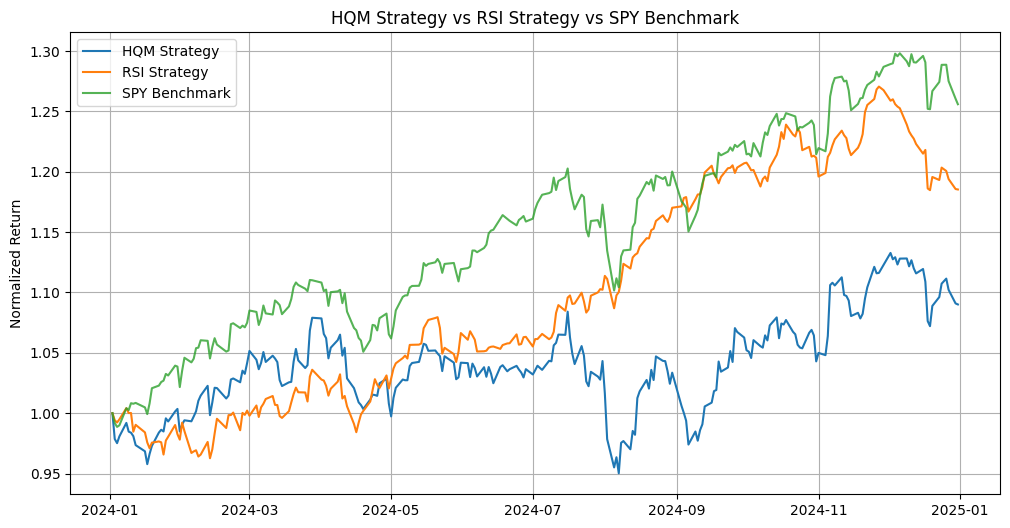

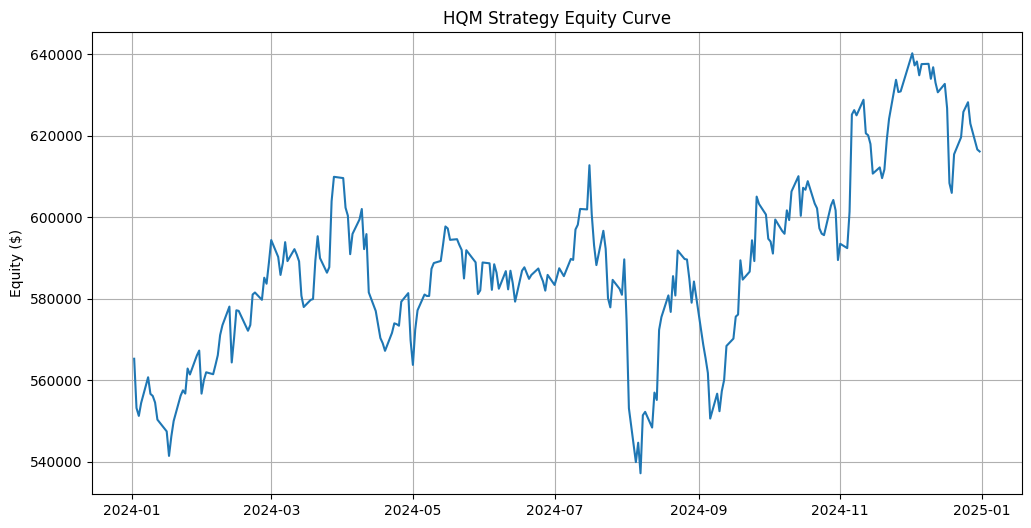

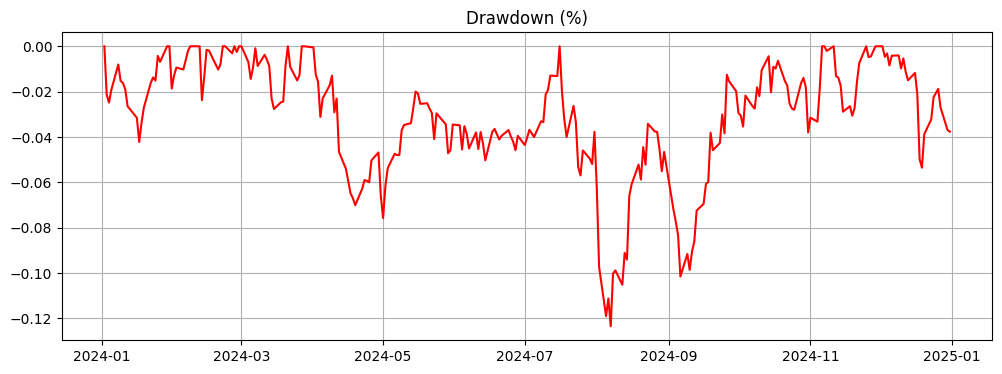

In [4]:
# ==========================================
# 2. Backtest (FULLY FIXED)
# ==========================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Load HQM Strategy Output
# ---------------------------------------------------------

file_path = "momentum_strategy.xlsx"
strategy = pd.read_excel(file_path)

tickers = strategy["Ticker"].tolist()
shares = strategy["Number of Shares to Buy"].tolist()

print(f"Loaded {len(tickers)} tickers from momentum_strategy.xlsx")


# ---------------------------------------------------------
# Load RSI Strategy Output
# ---------------------------------------------------------

rsi_file_path = "rsi_strategy.xlsx"
rsi_strategy = pd.read_excel(rsi_file_path)

rsi_tickers = rsi_strategy["Ticker"].tolist()
rsi_shares = rsi_strategy["Number of Shares to Buy"].tolist()

print(f"Loaded {len(rsi_tickers)} tickers from rsi_strategy.xlsx")


# ---------------------------------------------------------
# 2. Historical backtest window
# ---------------------------------------------------------
backtest_start = "2024-01-02"
backtest_end = "2025-01-02"
print("Backtest period:", backtest_start, "to", backtest_end)

# ---------------------------------------------------------
# 3. Safe price downloader
# ---------------------------------------------------------

def safe_download(tickers, start, end):
    raw = yf.download(
        tickers,
        start=start,
        end=end,
        progress=False,
        auto_adjust=True  # ensures consistent OHLCV
    )

    # Fix MultiIndex
    if isinstance(raw.columns, pd.MultiIndex):
        raw = raw["Close"]
    else:
        raw = raw["Close"]

    raw = raw.ffill()

    # Remove completely missing tickers
    good = [t for t in tickers if t in raw.columns and raw[t].dropna().shape[0] > 0]
    bad = set(tickers) - set(good)

    if bad:
        print("Removed tickers with no data:", bad)

    return raw[good], good


# ---------------------------------------------------------
# 4. Download HQM price data
# ---------------------------------------------------------

prices, good_tickers = safe_download(tickers, backtest_start, backtest_end)

# Sync shares list
shares = [shares[tickers.index(t)] for t in good_tickers]
tickers = good_tickers  # final clean list

# If no tickers left → cannot backtest
if len(tickers) == 0:
    raise ValueError("No valid tickers available for backtest period.")

# ---------------------------------------------------------
# Download RSI price data
# ---------------------------------------------------------
rsi_prices, rsi_good_tickers = safe_download(rsi_tickers, backtest_start, backtest_end)

# Sync shares list for RSI
rsi_shares = [rsi_shares[rsi_tickers.index(t)] for t in rsi_good_tickers]
rsi_tickers = rsi_good_tickers

if len(rsi_tickers) == 0:
    raise ValueError("No valid RSI tickers available for backtest period.")


# ---------------------------------------------------------
# 5. Compute HQM portfolio value
# ---------------------------------------------------------

portfolio_value = (prices[tickers] * shares).sum(axis=1)
portfolio_value = portfolio_value.to_frame("Portfolio")

portfolio_norm = portfolio_value["Portfolio"] / portfolio_value["Portfolio"].iloc[0]

# ---------------------------------------------------------
# Compute RSI Portfolio Value
# ---------------------------------------------------------

rsi_portfolio_value = (rsi_prices[rsi_tickers] * rsi_shares).sum(axis=1)
rsi_portfolio_value = rsi_portfolio_value.to_frame("RSI_Portfolio")

rsi_norm = rsi_portfolio_value["RSI_Portfolio"] / rsi_portfolio_value["RSI_Portfolio"].iloc[0]


# ---------------------------------------------------------
# 6. Benchmark SPY
# ---------------------------------------------------------

spy = yf.download(
    "SPY",
    start=backtest_start,
    end=backtest_end,
    progress=False,
    auto_adjust=True
)["Close"].ffill()

spy_norm = spy / spy.iloc[0]

# ---------------------------------------------------------
# 7. Performance Statistics
# ---------------------------------------------------------

returns = portfolio_value["Portfolio"].pct_change().dropna()

days = (portfolio_value.index[-1] - portfolio_value.index[0]).days
years = days / 365

cagr = (portfolio_value["Portfolio"].iloc[-1] / portfolio_value["Portfolio"].iloc[0]) ** (1 / years) - 1
vol = returns.std() * np.sqrt(252)
sharpe = cagr / vol

print("\n---------------- Performance ----------------")
print(f"CAGR: {cagr:.2%}")
print(f"Annual Volatility: {vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print("------------------------------------------------\n")

# ---------------------------------------------------------
# 8. Drawdown calculation & Stop-Loss (20%)
# ---------------------------------------------------------
portfolio_value["Peak"] = portfolio_value["Portfolio"].cummax()
portfolio_value["Drawdown"] = (portfolio_value["Portfolio"] - portfolio_value["Peak"]) / portfolio_value["Peak"]

# Apply Stop-Loss: freeze portfolio once drawdown exceeds -20%
stop_loss = -0.20
portfolio_with_stop = portfolio_value["Portfolio"].copy()
stop_triggered = False

for i in range(len(portfolio_with_stop)):
    if stop_triggered:
        portfolio_with_stop.iloc[i] = portfolio_with_stop.iloc[i-1]  # freeze equity after stop-loss
    elif portfolio_value["Drawdown"].iloc[i] <= stop_loss:
        stop_triggered = True
        portfolio_with_stop.iloc[i] = portfolio_with_stop.iloc[i]  # keep value at stop day

portfolio_value["Portfolio_StopLoss"] = portfolio_with_stop
portfolio_stop_norm = portfolio_value["Portfolio_StopLoss"] / portfolio_value["Portfolio_StopLoss"].iloc[0]


# ---------------------------------------------------------
# 9. Plot Portfolio vs SPY vs RSI
# ---------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(portfolio_norm, label="HQM Strategy")
plt.plot(rsi_norm, label="RSI Strategy")         # <-- NEW
plt.plot(spy_norm, label="SPY Benchmark", alpha=0.8)
plt.title("HQM Strategy vs RSI Strategy vs SPY Benchmark")
plt.ylabel("Normalized Return")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------------------------------------
# 10. Plot Equity Curve
# ---------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(portfolio_value["Portfolio"])
plt.title("HQM Strategy Equity Curve")
plt.ylabel("Equity ($)")
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 11. Drawdown Plot
# ---------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(portfolio_value["Drawdown"], color='red')
plt.title("Drawdown (%)")
plt.grid(True)
plt.show()



In [21]:
# ==========================================
# 3. Trading Engine
# ==========================================

import datetime
from datetime import date
import pandas as pd

try:
    import yfinance as yf
except ImportError:
    print("yfinance not installed. 'yahoo' source will not work.")
    yf = None


class MarketDataQuery:
    def __init__(self,
                 symbol: str,  # symbol means permno
                 time_frame: str,
                 start_date: str,
                 end_date: str,
                 frequency: str = '1d', # '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'
                 source: str = 'yahoo'): # default source is yahoo, it will ask yfinance to provide the data
        self.symbol = symbol
        self.time_frame = time_frame
        self.start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')  # convert string to datetime, opposite to strftime
        self.end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
        self.frequency = frequency
        self.source = source

        self._validate()

    # you have to validate your query condition each time
    def _validate(self):
        if self.start_date > self.end_date:
            raise ValueError('Start date must be before end date')
        valid_frequencies = ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

        if self.frequency not in valid_frequencies:
            raise ValueError('Frequency must be one of {}'.format(valid_frequencies))

    def fetch(self):
        if self.source == 'test':

            freq_map = {'1m': 'T', # these are pandas alias
                        '2m': '2T',
                        '5m': '5T',
                        '15m': '15T',
                        '30m': '30T',
                        '60m': '60T',
                        '90m': '90T',
                        '1h': 'H',
                        '1d': 'D',
                        '5d': '5D',
                        '1wk': 'W',
                        '1mo': 'MS',
                        '3mo': '3MS'} # 'D'
            pd_freq = freq_map.get(self.frequency)
            if not pd_freq:
                raise ValueError('Test source does not support frequency: {self.frequency}')

            dates = pd.date_range(start=self.start_date, end=self.end_date, freq=pd_freq) # get() looks up value of self.frequency in freq_map
            if len(dates) == 0 and self.start_date <= self.end_date: # Handle case where start/end are same day
                dates = pd.to_datetime([self.start_date]) # set the start_date as dates

            prices = [100 + i*0.5 for i in range(len(dates))]  # add 0.5 each day

            df = pd.DataFrame({'date': dates, 'price': prices})
            return df

        elif self.source == 'yahoo':
            if yf is None:
                raise ImportError("yfinance is not installed. Cannot use 'yahoo' source.")

            df = yf.download( # input your parameter
                self.symbol,
                start=self.start_date.strftime('%Y-%m-%d'), # convert the datetime object to string, then send it to API
                end=self.end_date.strftime('%Y-%m-%d'),
                interval=self.frequency,
            )
            df.reset_index(inplace=True)
            return df

        else:
            raise ValueError(f'Unknown source: {self.source}')


# PriceBar is a container after getting the data
class PriceBar:
    def __init__(self, date, open_price, close_price, high_price, low_price, volume):
        self.date = date
        self.open = open_price
        self.close = close_price
        self.high = high_price
        self.low = low_price
        self.volume = volume

    def mid_price(self):
        return (self.high + self.low) / 2

    def is_bullish(self):
        return self.open < self.close

    def is_bearish(self):
        return self.open > self.close

    def __repr__(self):
        return (f'PriceBar(date={self.date}, open={self.open}, close={self.close}, '
                f'high={self.high}, low={self.low}, volume={self.volume})')


class TradeOrder:
    def __init__(self, symbol, side, quantity, order_type='market', price=None):
        self.symbol = symbol.upper()
        self.side = side.upper()  # 'BUY' or 'SELL'
        self.quantity = quantity
        self.order_type = order_type.lower()
        self.price = price
        # These are now set internally, not passed as args
        self.timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        self.status = 'pending'

    def cancel(self):
        if self.status == 'pending':
            self.status = 'cancelled'

    def __repr__(self):
        return (f'TradeOrder(symbol={self.symbol}, side={self.side}, quantity={self.quantity}, '
                f'type={self.order_type}, price={self.price}, status={self.status})')


class MarketOrder(TradeOrder):
    def __init__(self, symbol, side, quantity):
        super().__init__(symbol, side, quantity, order_type='market')

    def execute(self, market_price):
        self.price = market_price
        self.status = 'filled'


class LimitOrder(TradeOrder):
    def __init__(self, symbol, side, quantity, limit_price):
        super().__init__(symbol, side, quantity, order_type='limit', price=limit_price)

    def execute(self, market_price):
        if self.side == 'BUY' and market_price <= self.price:
            self.status = 'filled'
        elif self.side == 'SELL' and market_price >= self.price:
            self.status = 'filled'


class OrderReceipt:
    def __init__(self, symbol, side, order, timestamp, executed_price=None, executed_quantity=0, status='pending'):
        self.order_id = id(order)
        self.symbol = symbol.upper()
        self.side = side.upper()
        self.original_quantity = order.quantity  # order here is an object from TradeOrder
        self.executed_quantity = executed_quantity
        self.executed_price = executed_price
        self.timestamp = timestamp  # Use passed timestamp
        self.status = status

    def __repr__(self):
        return (f'OrderReceipt(symbol={self.symbol.upper()}, side={self.side.upper()}, '
                f'executed_qty={self.executed_quantity}/{self.original_quantity}, '
                f'executed_price={self.executed_price}, status={self.status}, '
                f'timestamp={self.timestamp})')


class IConnector:  # defines a contract for how your system talks to any broker.
    def getMarketData(self, symbol, start_date, end_date):
        raise NotImplementedError('Subclasses must implement getMarketData')

    def submitOrder(self, order):
        raise NotImplementedError('Subclasses must implement submitOrder')

    def getAccountInfo(self):
        raise NotImplementedError('Subclasses must implement getAccountInfo')


class MockBrokerConnector(IConnector):  # provides a dummybroker
    def __init__(self):
        self.cash_balance = 100000.0
        self.positions = {}  # e.g., {'AAPL': 100}
        self.order_history = []
        self.current_market_price = 100.0  # Added for predictable testing

    def getMarketData(self, symbol, start_date, end_date):
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        prices = [100 + i * 0.5 for i in range(len(dates))]
        df = pd.DataFrame({'date': dates, 'symbol': symbol, 'price': prices})
        return df

    def submitOrder(self, order):
        # Use the broker's current market price
        order.execute(self.current_market_price)
        self.order_history.append(order)

        if order.status == 'filled':
            if order.side == 'BUY':
                cost = order.price * order.quantity
                self.cash_balance -= cost
                self.positions[order.symbol] = self.positions.get(order.symbol, 0) + order.quantity
            elif order.side == 'SELL':
                revenue = order.price * order.quantity
                self.cash_balance += revenue
                self.positions[order.symbol] = self.positions.get(order.symbol, 0) - order.quantity

        # Return a receipt
        receipt = OrderReceipt(
            symbol=order.symbol,
            side=order.side,
            order=order,
            timestamp=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            executed_price=order.price if order.status == 'filled' else None,
            executed_quantity=order.quantity if order.status == 'filled' else 0,
            status=order.status
        )
        return receipt

    def getAccountInfo(self):
        return {
            'cash_balance': self.cash_balance,
            'positions': self.positions,
            'order_history': self.order_history}
